# 🔬 Robust Nonlinear Control vs PID for a Piezoelectric Actuator
## Based on: Flores & Rakotondrabe, IEEE Control Systems Letters, Vol. 6, 2022

**"Robust Nonlinear Control for a Piezoelectric Actuator in a Robotic Hand Using Only Position Measurements"**

This notebook implements and compares:
1. **Robust Nonlinear Output-Feedback Control** (Observer + Hysteresis Compensation)
2. **Classical PID Control**

for a piezoelectrically actuated robotic hand with **Bouc-Wen hysteresis**.

### What students can explore:
- Effect of observer gain **θ** on state estimation convergence
- Effect of control gains (**k₁, k₂, κ₁**) on tracking performance
- PID tuning and its limitations with strong hysteresis
- Robustness under external disturbances
- Different hysteresis parameter sets

---
**Author:** Dr. Gerardo Flores, RAPTOR Lab, Texas A&M International University


## 📦 Setup & Imports


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
matplotlib.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 13,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'figure.figsize': (14, 8),
    'lines.linewidth': 1.5,
    'grid.alpha': 0.3,
})

try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False
    print("ipywidgets not available — running in static mode.")

print("✅ All imports successful!")


✅ All imports successful!


## 📐 System Model — Hammerstein Structure

The piezoelectric actuator is modeled as a **Hammerstein structure**:

**Hysteresis (Bouc-Wen):**
$$\dot{h} = A_{bw}\dot{u} - B_{bw}|\dot{u}|h - G_{bw}\dot{u}|h|$$

**Linear Dynamics:**
$$\dot{x} = Ax + B(d_p u - h) + \delta_x(t)$$

**Output (position measurement only):**
$$y = x$$

where $h$ is the **unmeasured** hysteresis state, $x$ is the position, $u$ is the voltage input, and $\delta_h$, $\delta_x$ are external disturbances.

### Key Challenge
The hysteresis state $h$ is **not directly measurable** — it must be estimated via a nonlinear observer.


In [2]:
# ---- Parameter Sets (from Table I of the paper) ----
PARAM_SETS = {
    "Set 1 (Baseline)":       {"Abw": 0.8,  "Bbw": 0.2,  "Gbw": 0.03, "dp": 0.3},
    "Set 2 (Wider loop)":     {"Abw": 0.9,  "Bbw": 0.1,  "Gbw": 0.01, "dp": 0.3},
    "Set 3 (Asymmetric)":     {"Abw": 0.5,  "Bbw": 0.15, "Gbw": 0.1,  "dp": 0.3},
    "Set 4 (Strong hyst.)":   {"Abw": 1.2,  "Bbw": 0.05, "Gbw": 0.02, "dp": 0.3},
}

# Linear dynamics parameters
TAU = 0.001       # Time constant (s)
A_LIN = -1.0/TAU  # = -1000
B_LIN = 1.0/TAU   # = 1000

# Reference signal
AMP = 40.0           # Amplitude (μm)
FREQ = 1.0           # Frequency (Hz)
OMEGA = 2*np.pi*FREQ

print("Parameter sets loaded:")
for name, p in PARAM_SETS.items():
    print(f"  {name}: Abw={p['Abw']}, Bbw={p['Bbw']}, Gbw={p['Gbw']}, dp={p['dp']}")
print(f"\nReference: {AMP} μm @ {FREQ} Hz")
print(f"Linear dynamics: τ = {TAU*1000} ms  →  A = {A_LIN}, B = {B_LIN}")


Parameter sets loaded:
  Set 1 (Baseline): Abw=0.8, Bbw=0.2, Gbw=0.03, dp=0.3
  Set 2 (Wider loop): Abw=0.9, Bbw=0.1, Gbw=0.01, dp=0.3
  Set 3 (Asymmetric): Abw=0.5, Bbw=0.15, Gbw=0.1, dp=0.3
  Set 4 (Strong hyst.): Abw=1.2, Bbw=0.05, Gbw=0.02, dp=0.3

Reference: 40.0 μm @ 1.0 Hz
Linear dynamics: τ = 1.0 ms  →  A = -1000.0, B = 1000.0


## ⚙️ Core Simulation Functions


In [3]:
def reference_signal(t, amp=AMP, omega=OMEGA):
    """Desired trajectory and its derivative."""
    xd = amp * np.sin(omega * t)
    xd_dot = amp * omega * np.cos(omega * t)
    xd_ddot = -amp * omega**2 * np.sin(omega * t)
    return xd, xd_dot, xd_ddot


def disturbances(t, enable=False, dx_amp=30.0, dh_amp=25.0):
    """External disturbances δ_x and δ_h."""
    if not enable:
        return 0.0, 0.0
    delta_x = dx_amp
    delta_h = dh_amp * np.sin(t)
    return delta_x, delta_h


def bouc_wen_dhdt(h, u_dot, Abw, Bbw, Gbw):
    """Bouc-Wen hysteresis dynamics: ḣ (without disturbance)."""
    return Abw * u_dot - Bbw * abs(u_dot) * h - Gbw * u_dot * abs(h)

print("✅ Core functions defined")


✅ Core functions defined


## 🔧 Robust Nonlinear Output-Feedback Controller

### Architecture:
1. **High-Gain Observer** estimates the hysteresis state $\hat{h}$ from position measurement $y = x$
2. **Feedforward + Feedback Controller** uses $\hat{h}$ to compute the desired voltage

### Observer (High-Gain):
$$\dot{\hat{z}} = \Gamma\hat{z} + g(\hat{z}, \dot{u}) - S^{-1}\bar{C}^\top(\hat{z}_1 - z_1)$$

### Controller:
The desired net input $\xi_d$ makes the tracking error $\tilde{x} = x - x_d$ decay exponentially:
$$\xi_d = \frac{1}{B}\left[-(A+\kappa_1)\tilde{x} - Ax_d + \dot{x}_d\right]$$

The desired voltage compensates for hysteresis:
$$u_{desired} = \frac{\xi_d + \hat{h}}{d_p}$$

Fast tracking law drives $u \to u_{desired}$:
$$\dot{u} = k_1(u_{desired} - u) + k_2 \mathrm{sgn}(u_{desired}-u)\sqrt{|u_{desired}-u|}$$


In [4]:
def simulate_robust_control(params, ctrl_gains, obs_gain, t_span, dt,
                            disturbance=False, dx_amp=30.0, dh_amp=25.0,
                            x0=3.0, h0=-2.0, u0=0.0):
    """
    Simulate the output-feedback system with observer-based hysteresis compensation.
    States: [x, h, u, x_hat, h_hat]
    """
    Abw, Bbw, Gbw, dp = params["Abw"], params["Bbw"], params["Gbw"], params["dp"]
    k1, k2, kappa1 = ctrl_gains["k1"], ctrl_gains["k2"], ctrl_gains["kappa1"]
    theta = obs_gain

    # Observer gain matrix via Riccati-like solution
    B = B_LIN
    S11 = 1.0/theta
    S12 = B/(theta**2)
    S22 = 2.0*B**2/(theta**3)
    det_S = S11*S22 - S12**2
    L1 = S22 / det_S
    L2 = -S12 / det_S

    u_max = 250.0
    h_sat = 3.0 * AMP * max(abs(Abw), 1.0)

    def sat(val, bound):
        return np.clip(val, -bound, bound)

    def dynamics(t, state):
        x, h, u, x_hat, h_hat = state
        xd, xd_dot, _ = reference_signal(t)
        delta_x, delta_h = disturbances(t, disturbance, dx_amp, dh_amp)

        h_hat_s = sat(h_hat, h_sat)  # peaking prevention

        # Desired net input ξd (makes dx̃/dt = -κ1*x̃)
        x_tilde = x - xd
        xi_d = (1.0/B_LIN) * (-(A_LIN + kappa1)*x_tilde - A_LIN*xd + xd_dot)

        # Desired voltage: u_desired = (ξd + ĥ) / dp
        u_desired = (xi_d + h_hat_s) / dp
        u_desired = sat(u_desired, u_max)

        # Fast tracking of u toward u_desired
        u_err = u_desired - u
        u_dot = k1 * u_err + k2 * np.sign(u_err) * np.sqrt(max(abs(u_err), 1e-14))
        u_dot = sat(u_dot, 5000.0)

        # Anti-windup
        u_clipped = sat(u, u_max)
        if abs(u) > u_max and u * u_dot > 0:
            u_dot = 0.0

        # True plant dynamics
        dh = bouc_wen_dhdt(h, u_dot, Abw, Bbw, Gbw) + delta_h
        dx = A_LIN * x + B_LIN * (dp * u_clipped - h) + delta_x

        # Observer dynamics
        innovation = x_hat - x
        g1 = A_LIN * x_hat + B_LIN * dp * u_clipped
        g2 = bouc_wen_dhdt(h_hat_s, u_dot, Abw, Bbw, Gbw)
        dx_hat = -B_LIN * h_hat_s + g1 - L1 * innovation
        dh_hat = g2 - L2 * innovation

        return [dx, dh, u_dot, dx_hat, dh_hat]

    y0 = [x0, h0, u0, 0.0, 0.0]
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(dynamics, t_span, y0, method='LSODA',
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)
    return sol

print("✅ Robust controller defined")


✅ Robust controller defined


## 📏 Classical PID Control

For comparison, a standard PID controller is applied directly:
$$u(t) = K_p e(t) + K_i \int_0^t e(\tau)d\tau + K_d \dot{e}(t)$$

where $e(t) = y_d(t) - y(t)$ is the tracking error.

**Note:** The PID does **NOT** use any hysteresis model information — it treats the actuator as a "black box".


In [5]:
def simulate_pid(params, pid_gains, t_span, dt,
                 disturbance=False, dx_amp=30.0, dh_amp=25.0,
                 x0=3.0, h0=-2.0):
    """
    Simulate PID control. States: [x, h, u, integral_error]
    u evolves via first-order filter: τ_u * du/dt = u_pid - u
    """
    Abw, Bbw, Gbw, dp = params["Abw"], params["Bbw"], params["Gbw"], params["dp"]
    Kp, Ki, Kd = pid_gains["Kp"], pid_gains["Ki"], pid_gains["Kd"]
    u_max = 200.0
    tau_u = 0.001

    def dynamics(t, state):
        x, h, u, int_err = state
        xd, xd_dot, _ = reference_signal(t)
        delta_x, delta_h = disturbances(t, disturbance, dx_amp, dh_amp)

        err = xd - x
        u_pid = np.clip(Kp * err + Ki * int_err + Kd * xd_dot, -u_max, u_max)
        u_dot = (u_pid - u) / tau_u

        dh = Abw * u_dot - Bbw * abs(u_dot) * h - Gbw * u_dot * abs(h) + delta_h
        dx = A_LIN * x + B_LIN * (dp * u - h) + delta_x
        d_int = err
        return [dx, dh, u_dot, d_int]

    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(dynamics, t_span, [x0, h0, 0.0, 0.0], method='LSODA',
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)
    return sol


def simulate_open_loop(params, t_span, dt, u_amp=150.0, x0=0.0, h0=0.0):
    """Open-loop: apply sinusoidal voltage, observe hysteresis."""
    Abw, Bbw, Gbw, dp = params["Abw"], params["Bbw"], params["Gbw"], params["dp"]

    def dynamics(t, state):
        x, h = state
        u = u_amp * np.sin(OMEGA * t)
        u_dot = u_amp * OMEGA * np.cos(OMEGA * t)
        dh = Abw * u_dot - Bbw * abs(u_dot) * h - Gbw * u_dot * abs(h)
        dx = A_LIN * x + B_LIN * (dp * u - h)
        return [dx, dh]

    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(dynamics, t_span, [x0, h0], method='LSODA',
                    t_eval=t_eval, rtol=1e-6, atol=1e-8)
    return sol

print("✅ PID and Open-Loop functions defined")


✅ PID and Open-Loop functions defined


## 📊 Visualization Functions


In [6]:
COLORS = {
    'robust': '#1b5e8c', 'pid': '#c0392b', 'ref': '#2c3e50',
    'observer': '#16a085', 'openloop': '#8e44ad', 'dist': '#e67e22',
}

def plot_comparison(sol_robust, sol_pid, sol_ol, params_name,
                    ctrl_gains, pid_gains, obs_gain, disturbance=False, save_name=None):
    """Generate comprehensive comparison plots."""
    fig = plt.figure(figsize=(16, 14))
    gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.3)

    # (a) Open-loop hysteresis map
    ax1 = fig.add_subplot(gs[0, 0])
    t_ol, x_ol = sol_ol.t, sol_ol.y[0]
    u_ol = 150.0 * np.sin(OMEGA * t_ol)
    mask = t_ol > t_ol[-1] - 2.0/FREQ
    ax1.plot(u_ol[mask], x_ol[mask], color=COLORS['openloop'], lw=1.5)
    ax1.set_xlabel('Voltage $u$ (V)'); ax1.set_ylabel('Position $y$ (μm)')
    ax1.set_title('(a) Open-Loop: Hysteresis Map $(u,y)$'); ax1.grid(True, alpha=0.3)

    # (b) Robust closed-loop map
    ax2 = fig.add_subplot(gs[0, 1])
    t_r, x_r = sol_robust.t, sol_robust.y[0]
    xd_r = AMP * np.sin(OMEGA * t_r)
    mask = t_r > t_r[-1] - 2.0/FREQ
    ax2.plot(xd_r[mask], x_r[mask], color=COLORS['robust'], lw=1.5)
    ax2.plot([-AMP, AMP], [-AMP, AMP], 'k--', lw=0.8, alpha=0.4, label='Ideal')
    ax2.set_xlabel('$y_d$ (μm)'); ax2.set_ylabel('$y$ (μm)')
    ax2.set_title('(b) Robust Control: Map $(y_d, y)$'); ax2.legend(loc='lower right'); ax2.grid(True, alpha=0.3)

    # (c) PID closed-loop map
    ax3 = fig.add_subplot(gs[0, 2])
    t_p, x_p = sol_pid.t, sol_pid.y[0]
    xd_p = AMP * np.sin(OMEGA * t_p)
    mask = t_p > t_p[-1] - 2.0/FREQ
    ax3.plot(xd_p[mask], x_p[mask], color=COLORS['pid'], lw=1.5)
    ax3.plot([-AMP, AMP], [-AMP, AMP], 'k--', lw=0.8, alpha=0.4, label='Ideal')
    ax3.set_xlabel('$y_d$ (μm)'); ax3.set_ylabel('$y$ (μm)')
    ax3.set_title('(c) PID Control: Map $(y_d, y)$'); ax3.legend(loc='lower right'); ax3.grid(True, alpha=0.3)

    # (d) Position tracking
    ax4 = fig.add_subplot(gs[1, :2])
    ax4.plot(t_r, AMP*np.sin(OMEGA*t_r), 'k--', lw=1, alpha=0.5, label='$y_d$')
    ax4.plot(t_r, x_r, color=COLORS['robust'], lw=1.5, label='Robust')
    ax4.plot(t_p, x_p, color=COLORS['pid'], lw=1.2, ls='-.', label='PID')
    ax4.set_xlabel('Time (s)'); ax4.set_ylabel('Position $y$ (μm)')
    ax4.set_title('(d) Position Tracking: Robust vs PID'); ax4.legend(loc='upper right'); ax4.grid(True, alpha=0.3)

    # (e) Tracking error (steady state)
    ax5 = fig.add_subplot(gs[1, 2])
    err_r = AMP*np.sin(OMEGA*t_r) - x_r
    err_p = AMP*np.sin(OMEGA*t_p) - x_p
    mask_r = t_r > t_r[-1] - 3.0/FREQ
    mask_p = t_p > t_p[-1] - 3.0/FREQ
    ax5.plot(t_r[mask_r], err_r[mask_r], color=COLORS['robust'], lw=1.5, label='Robust')
    ax5.plot(t_p[mask_p], err_p[mask_p], color=COLORS['pid'], lw=1.2, ls='-.', label='PID')
    ax5.set_xlabel('Time (s)'); ax5.set_ylabel('Error $y_d - y$ (μm)')
    ax5.set_title('(e) Steady-State Tracking Error'); ax5.legend(); ax5.grid(True, alpha=0.3)

    # (f) Observer convergence
    ax6 = fig.add_subplot(gs[2, 0])
    eps_x = sol_robust.y[3] - x_r
    eps_h = sol_robust.y[4] - sol_robust.y[1]
    ax6.plot(t_r, eps_x, color=COLORS['observer'], lw=1.2, label=r'$\hat{x}-x$')
    ax6.plot(t_r, eps_h, color=COLORS['dist'], lw=1.2, label=r'$\hat{h}-h$')
    ax6.set_xlabel('Time (s)'); ax6.set_ylabel('Observer Error')
    ax6.set_title(f'(f) Observer Convergence ($\\theta={obs_gain}$)'); ax6.legend(); ax6.grid(True, alpha=0.3)
    ax6.set_xlim([0, min(0.5, t_r[-1])])

    # (g) Control voltage
    ax7 = fig.add_subplot(gs[2, 1])
    ax7.plot(t_r, sol_robust.y[2], color=COLORS['robust'], lw=1.2, label='Robust $u$')
    ax7.plot(t_p, sol_pid.y[2], color=COLORS['pid'], lw=1, ls='-.', label='PID $u$')
    ax7.set_xlabel('Time (s)'); ax7.set_ylabel('Voltage $u$ (V)')
    ax7.set_title('(g) Control Input'); ax7.legend(); ax7.grid(True, alpha=0.3)

    # (h) Performance metrics
    ax8 = fig.add_subplot(gs[2, 2]); ax8.axis('off')
    rmse_r = np.sqrt(np.mean(err_r[mask_r]**2))
    rmse_p = np.sqrt(np.mean(err_p[mask_p]**2))
    max_r = np.max(np.abs(err_r[mask_r]))
    max_p = np.max(np.abs(err_p[mask_p]))
    dist_str = "ON" if disturbance else "OFF"
    info = (f"━━━ Performance Metrics ━━━\n\n"
            f"Parameters: {params_name}\nDisturbances: {dist_str}\n\n"
            f"""{'Metric':<18}{'Robust':>10}{'PID':>10}\n{'─'*38}\n"""
            f"""{'RMSE (μm)':<18}{rmse_r:>10.3f}{rmse_p:>10.3f}\n"""
            f"""{'Max |e| (μm)':<18}{max_r:>10.3f}{max_p:>10.3f}\n\n"""
            f"━━━ Control Gains ━━━\n"
            f"k₁={ctrl_gains['k1']}, k₂={ctrl_gains['k2']}\n"
            f"κ₁={ctrl_gains['kappa1']}, θ={obs_gain}\n\n"
            f"━━━ PID Gains ━━━\nKp={pid_gains['Kp']}, Ki={pid_gains['Ki']}\nKd={pid_gains['Kd']}")
    ax8.text(0.05, 0.95, info, transform=ax8.transAxes, fontsize=10,
             fontfamily='monospace', verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', alpha=0.8))

    fig.suptitle(f'Piezoelectric Actuator Control Comparison — {params_name}', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_name:
        fig.savefig(save_name, dpi=150, bbox_inches='tight')
    plt.show()


def plot_observer_detail(sol_robust, obs_gain):
    """Detailed observer analysis."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    t = sol_robust.t
    x, h, x_hat, h_hat = sol_robust.y[0], sol_robust.y[1], sol_robust.y[3], sol_robust.y[4]

    axes[0,0].plot(t, x, 'k', lw=1.5, label='$x$ (true)')
    axes[0,0].plot(t, x_hat, '--', color=COLORS['observer'], lw=1.2, label=r'$\hat{x}$')
    axes[0,0].set_title('(a) Position: True vs Estimated'); axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3); axes[0,0].set_xlim([0,1.0])

    axes[0,1].plot(t, h, 'k', lw=1.5, label='$h$ (true)')
    axes[0,1].plot(t, h_hat, '--', color=COLORS['observer'], lw=1.2, label=r'$\hat{h}$')
    axes[0,1].set_title('(b) Hysteresis: True vs Estimated'); axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3); axes[0,1].set_xlim([0,1.0])

    axes[1,0].plot(t, x_hat-x, color=COLORS['observer'], lw=1.2, label=r'$\epsilon_x$')
    axes[1,0].plot(t, h_hat-h, color=COLORS['dist'], lw=1.2, label=r'$\epsilon_h$')
    axes[1,0].set_title(f'(c) Observer Errors ($\\theta={obs_gain}$)'); axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xlabel('Time (s)'); axes[1,0].set_xlim([0,0.5])

    eps_norm = np.sqrt((x_hat-x)**2 + (h_hat-h)**2)
    axes[1,1].semilogy(t, eps_norm+1e-16, color=COLORS['robust'], lw=1.5)
    axes[1,1].set_title(r'(d) Observer Error Norm $\|\epsilon\|$ (log scale)'); axes[1,1].set_xlabel('Time (s)')
    axes[1,1].grid(True, alpha=0.3); axes[1,1].set_xlim([0,1.0])

    fig.suptitle(f'Observer Convergence Analysis (θ = {obs_gain})', fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()


def plot_hysteresis_sets(params_dict, ctrl_gains, obs_gain, t_span, dt):
    """Test robust control across all parameter sets."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    for idx, (name, p) in enumerate(params_dict.items()):
        ax = axes.flatten()[idx]
        print(f"  Simulating {name}...")
        sol = simulate_robust_control(p, ctrl_gains, obs_gain, t_span, dt)
        t, x = sol.t, sol.y[0]
        ax.plot(t, x, color=COLORS['robust'], lw=1.2, label='$y$')
        ax.plot(t, AMP*np.sin(OMEGA*t), 'k--', lw=0.8, alpha=0.4, label='$y_d$')
        ax.set_title(name); ax.set_xlabel('Time (s)'); ax.set_ylabel('Position (μm)')
        ax.legend(loc='upper right', fontsize=9); ax.grid(True, alpha=0.3)
    fig.suptitle('Robust Control Across Parameter Sets', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

print("✅ Plotting functions defined")


✅ Plotting functions defined


## 🚀 Run Simulation with Default Parameters

**Control gains:** k₁ = 2000, k₂ = 50, κ₁ = 500
**Observer gain:** θ = 100
**PID gains:** Kp = 5, Ki = 50, Kd = 0.001


Running simulations (Set 1, no disturbances)...
  [1/3] Open-loop...
  [2/3] Robust nonlinear control...
  [3/3] PID control...
Done!



/tmp/ipython-input-3897534085.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


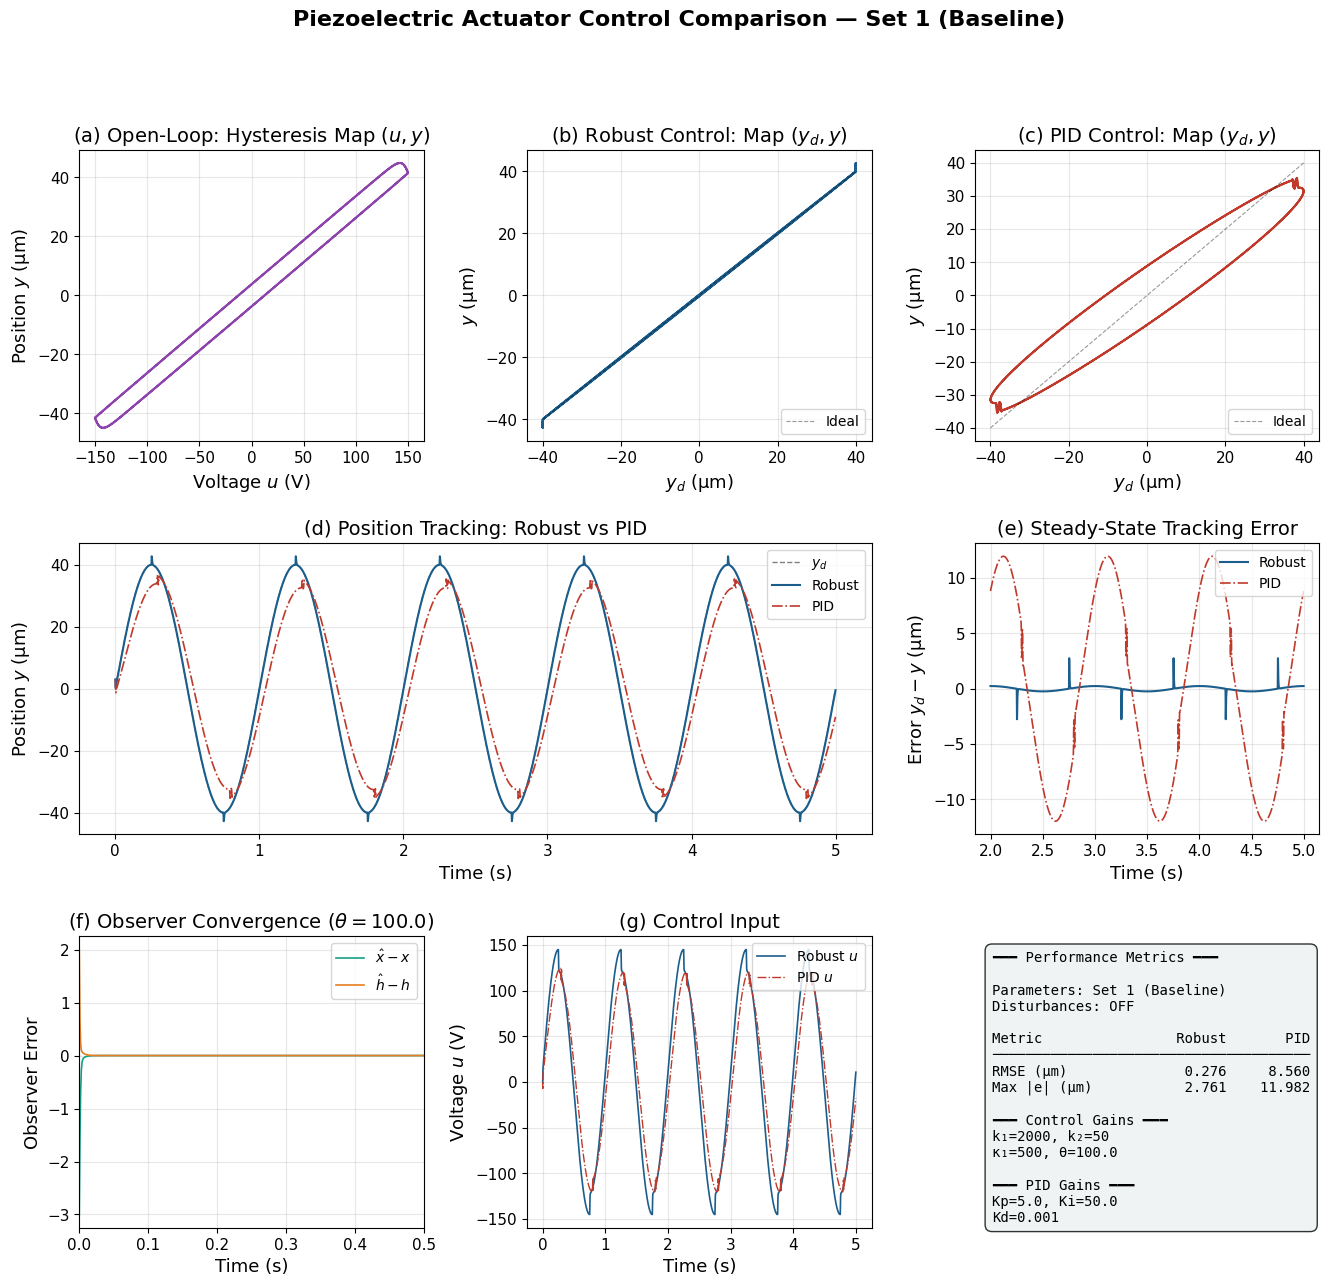

In [7]:
# Default gains
ctrl_gains_default = {"k1": 2000, "k2": 50, "kappa1": 500}
pid_gains_default = {"Kp": 5.0, "Ki": 50.0, "Kd": 0.001}
obs_gain_default = 100.0

T_FINAL = 5.0
DT = 0.001

params = PARAM_SETS["Set 1 (Baseline)"]

print("Running simulations (Set 1, no disturbances)...")
print("  [1/3] Open-loop...")
sol_ol = simulate_open_loop(params, [0, T_FINAL], DT, u_amp=150.0)
print("  [2/3] Robust nonlinear control...")
sol_robust = simulate_robust_control(params, ctrl_gains_default, obs_gain_default, [0, T_FINAL], DT)
print("  [3/3] PID control...")
sol_pid = simulate_pid(params, pid_gains_default, [0, T_FINAL], DT)
print("Done!\n")

plot_comparison(sol_robust, sol_pid, sol_ol,
                "Set 1 (Baseline)", ctrl_gains_default,
                pid_gains_default, obs_gain_default)


## 📐 Observer Convergence Analysis


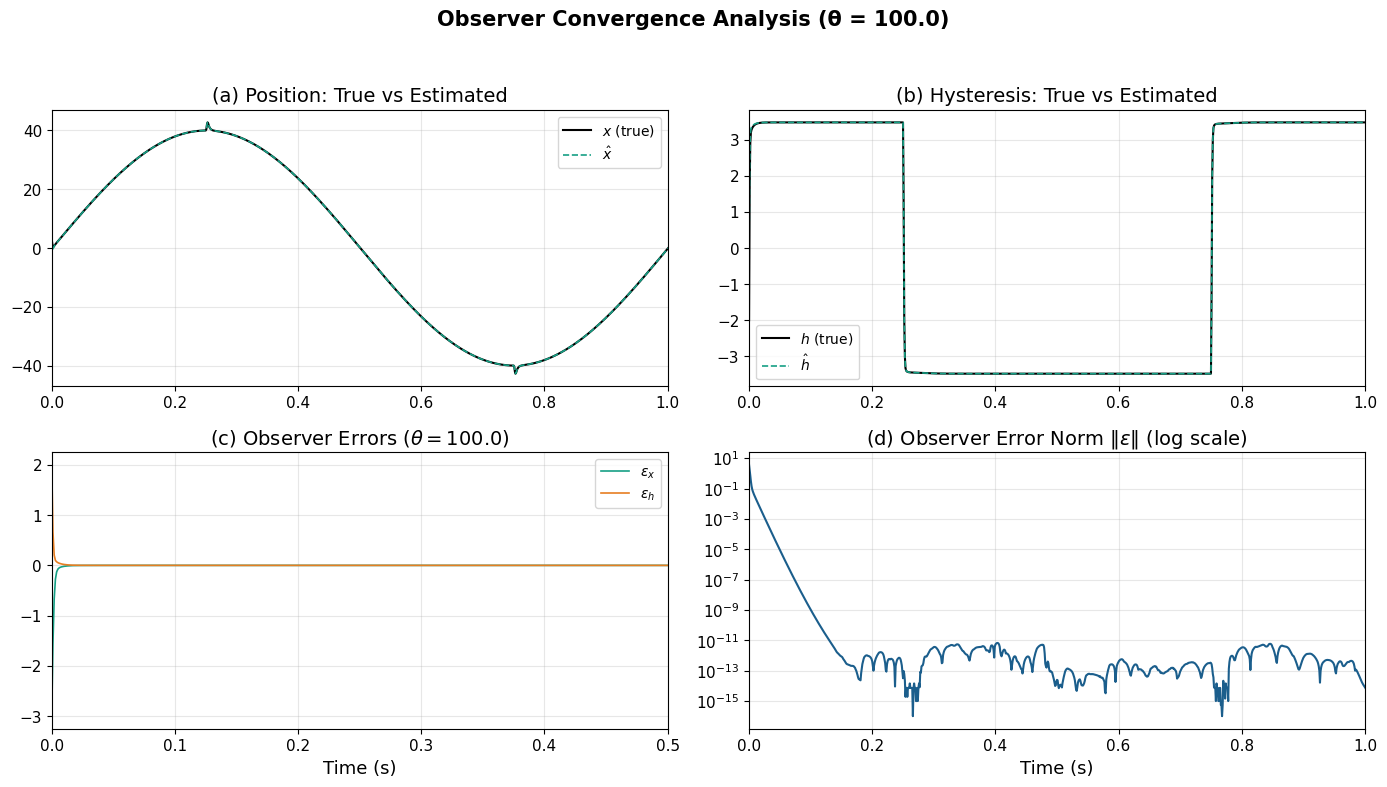

In [8]:
plot_observer_detail(sol_robust, obs_gain_default)


## 📊 All Parameter Sets


Testing across all parameter sets:
  Simulating Set 1 (Baseline)...
  Simulating Set 2 (Wider loop)...
  Simulating Set 3 (Asymmetric)...
  Simulating Set 4 (Strong hyst.)...


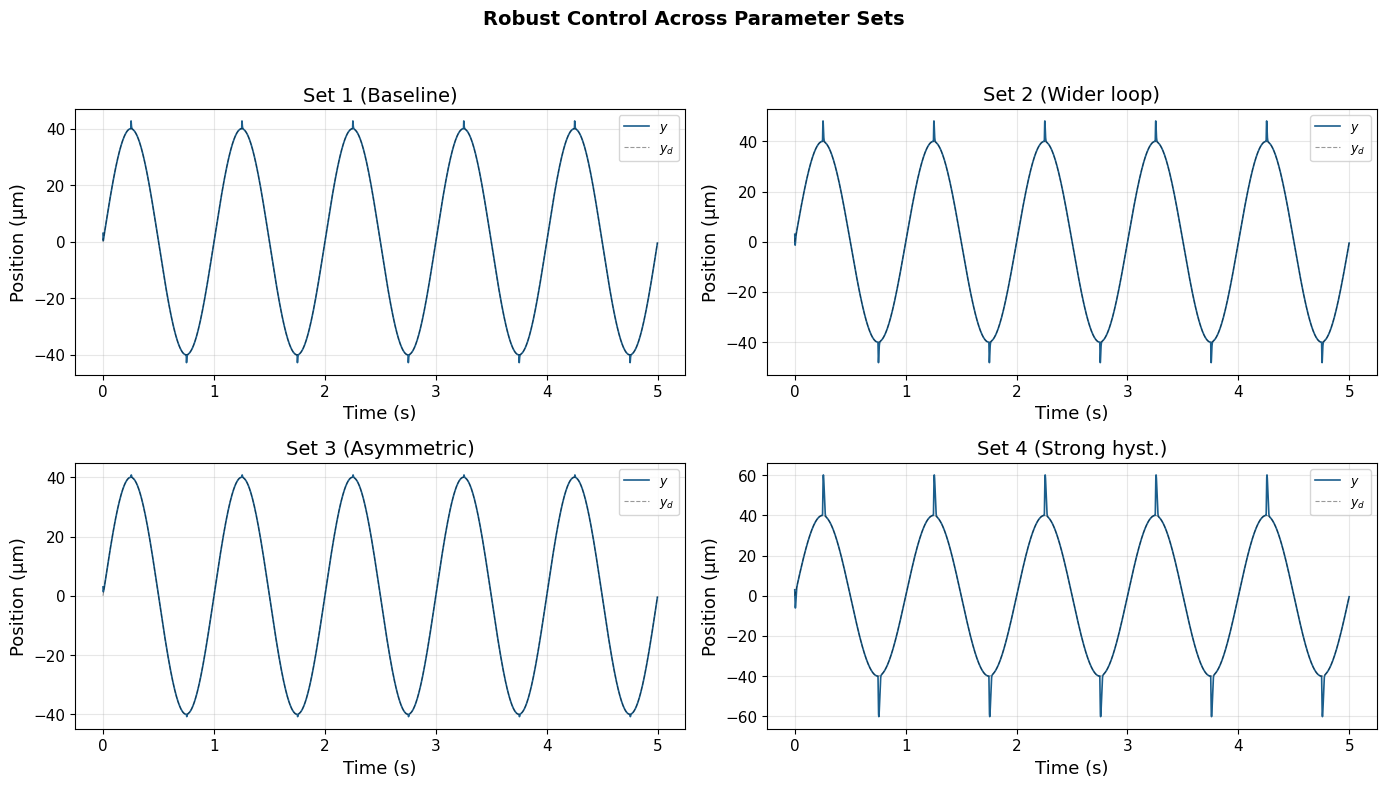

In [13]:
print("Testing across all parameter sets:")
plot_hysteresis_sets(PARAM_SETS, ctrl_gains_default, obs_gain_default, [0, T_FINAL], DT)


## 🌊 Robustness Under External Disturbances

Testing with δ_x = 30 μm (constant offset) and δ_h = 25 sin(t) μm (oscillating).


Simulation with disturbances...


/tmp/ipython-input-3897534085.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


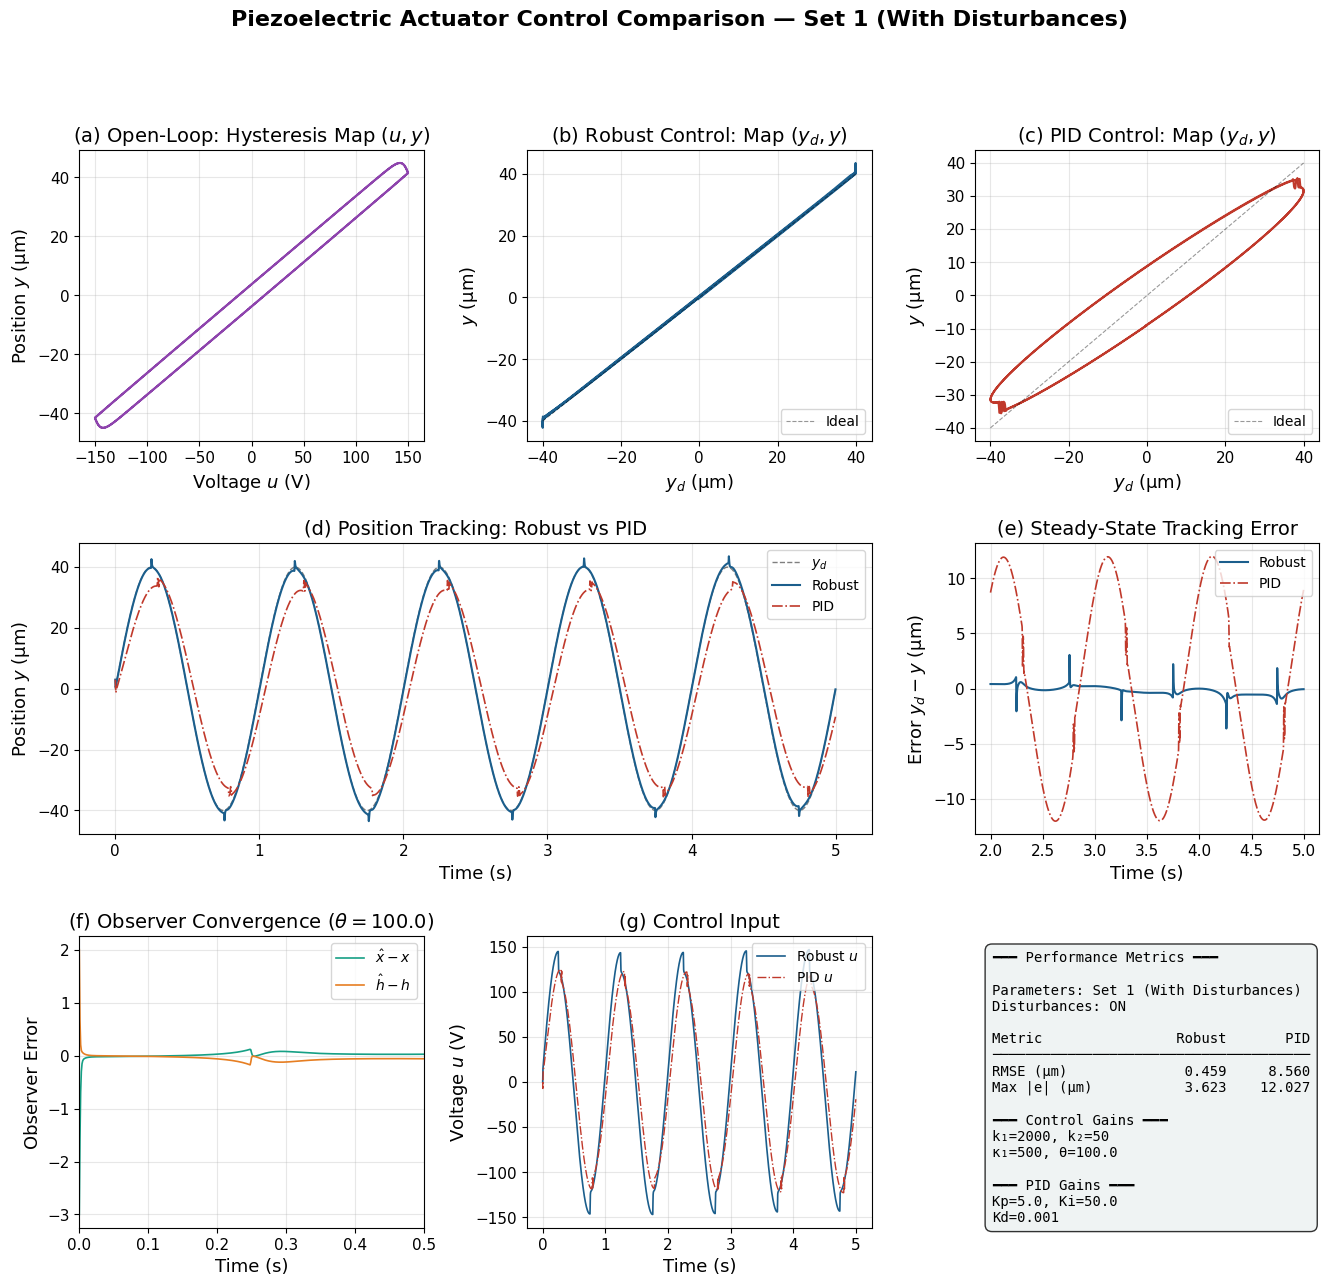

In [10]:
print("Simulation with disturbances...")
sol_robust_d = simulate_robust_control(params, ctrl_gains_default, obs_gain_default,
                                        [0, T_FINAL], DT, disturbance=True)
sol_pid_d = simulate_pid(params, pid_gains_default, [0, T_FINAL], DT, disturbance=True)
sol_ol_d = simulate_open_loop(params, [0, T_FINAL], DT)

plot_comparison(sol_robust_d, sol_pid_d, sol_ol_d,
                "Set 1 (With Disturbances)", ctrl_gains_default,
                pid_gains_default, obs_gain_default, disturbance=True)


## 🎛️ Interactive Parameter Exploration

Use the sliders below to explore how different parameters affect performance.
Press **▶ Run Simulation** after adjusting parameters.


In [11]:
if INTERACTIVE:
    style = {'description_width': '120px'}
    layout = widgets.Layout(width='400px')

    w_k1 = widgets.FloatSlider(value=2000, min=100, max=5000, step=100,
                                description='k₁ (tracking):', style=style, layout=layout)
    w_k2 = widgets.FloatSlider(value=50, min=1, max=200, step=5,
                                description='k₂ (√ term):', style=style, layout=layout)
    w_kappa1 = widgets.FloatSlider(value=500, min=10, max=2000, step=10,
                                    description='κ₁ (virtual):', style=style, layout=layout)
    w_theta = widgets.FloatSlider(value=100, min=10, max=500, step=10,
                                   description='θ (observer):', style=style, layout=layout)

    w_kp = widgets.FloatSlider(value=5.0, min=0.1, max=20, step=0.1,
                                description='Kp:', style=style, layout=layout)
    w_ki = widgets.FloatSlider(value=50.0, min=0, max=200, step=5,
                                description='Ki:', style=style, layout=layout)
    w_kd = widgets.FloatSlider(value=0.001, min=0.0, max=0.01, step=0.0005,
                                description='Kd:', style=style, layout=layout, readout_format='.4f')

    w_params = widgets.Dropdown(options=list(PARAM_SETS.keys()),
                                 value="Set 1 (Baseline)",
                                 description='Param Set:', style=style, layout=layout)
    w_dist = widgets.Checkbox(value=False, description='Enable disturbances', style=style)
    w_tfinal = widgets.FloatSlider(value=5, min=2, max=20, step=1,
                                    description='T_final (s):', style=style, layout=layout)

    run_button = widgets.Button(description='▶ Run Simulation', button_style='success',
                                 layout=widgets.Layout(width='200px', height='40px'))
    output = widgets.Output()

    def on_run(b):
        with output:
            clear_output(wait=True)
            cg = {"k1": w_k1.value, "k2": w_k2.value, "kappa1": w_kappa1.value}
            pg = {"Kp": w_kp.value, "Ki": w_ki.value, "Kd": w_kd.value}
            p = PARAM_SETS[w_params.value]
            tf = w_tfinal.value
            dist = w_dist.value
            print(f"🔄 Running: {w_params.value}, T={tf}s, Dist={'ON' if dist else 'OFF'}")
            try:
                sol_ol_i = simulate_open_loop(p, [0, tf], DT)
                sol_r_i = simulate_robust_control(p, cg, w_theta.value, [0, tf], DT, disturbance=dist)
                sol_p_i = simulate_pid(p, pg, [0, tf], DT, disturbance=dist)
                plot_comparison(sol_r_i, sol_p_i, sol_ol_i, w_params.value, cg, pg, w_theta.value, disturbance=dist)
                plot_observer_detail(sol_r_i, w_theta.value)
            except Exception as ex:
                print(f"❌ Error: {ex}")
                import traceback; traceback.print_exc()

    run_button.on_click(on_run)

    robust_box = widgets.VBox([widgets.HTML('<h4>🔧 Robust Control</h4>'), w_k1, w_k2, w_kappa1, w_theta])
    pid_box = widgets.VBox([widgets.HTML('<h4>📏 PID Control</h4>'), w_kp, w_ki, w_kd])
    system_box = widgets.VBox([widgets.HTML('<h4>⚙️ System</h4>'), w_params, w_dist, w_tfinal])
    display(widgets.VBox([widgets.HBox([robust_box, pid_box, system_box]), run_button, output]))
else:
    print("💡 Run in Google Colab for interactive sliders!")


## 🔍 Study: Effect of Observer Gain θ

The observer gain θ controls convergence speed:
- **Small θ** → slow but smooth convergence
- **Large θ** → fast convergence but potential **peaking** (transient spikes)


  θ = 20...
  θ = 100...
  θ = 300...


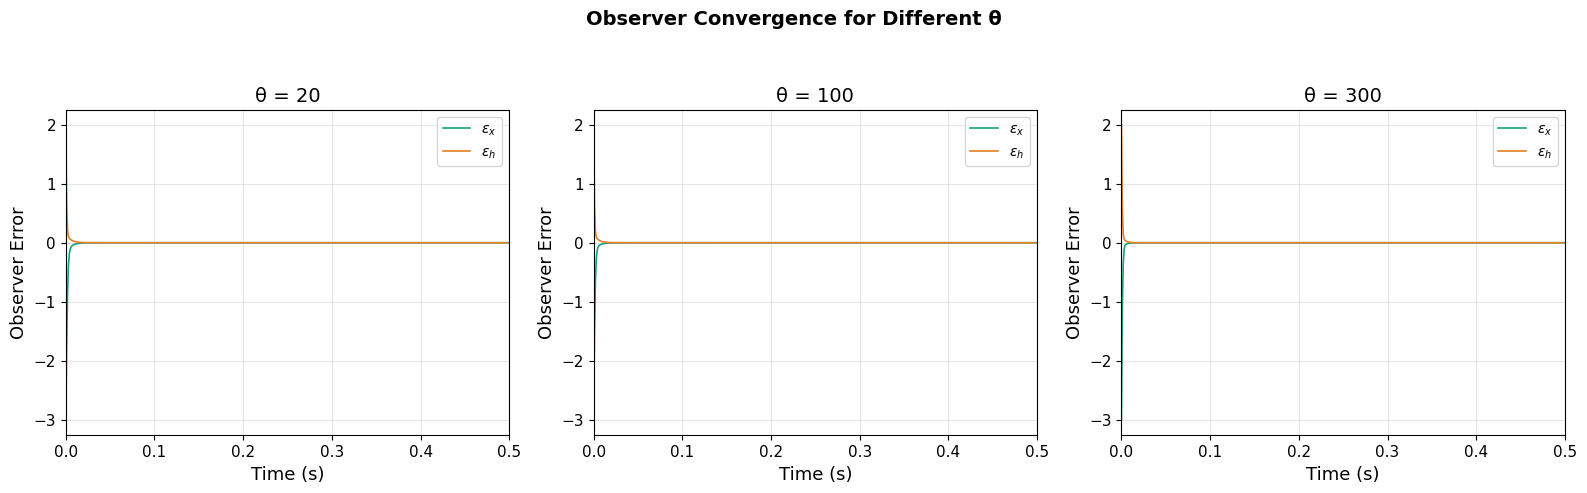

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for idx, theta_val in enumerate([20, 100, 300]):
    print(f"  θ = {theta_val}...")
    sol = simulate_robust_control(params, ctrl_gains_default, theta_val, [0, 2], DT)
    t = sol.t
    axes[idx].plot(t, sol.y[3]-sol.y[0], color=COLORS['observer'], lw=1.2, label=r'$\epsilon_x$')
    axes[idx].plot(t, sol.y[4]-sol.y[1], color=COLORS['dist'], lw=1.2, label=r'$\epsilon_h$')
    axes[idx].set_title(f'θ = {theta_val}'); axes[idx].set_xlabel('Time (s)')
    axes[idx].set_ylabel('Observer Error'); axes[idx].legend(); axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 0.5])
fig.suptitle('Observer Convergence for Different θ', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.93]); plt.show()


## 📋 Summary & Exercises

### Key Takeaways:
1. **Robust Nonlinear Control** achieves near-perfect hysteresis compensation by estimating $h$ with a nonlinear observer
2. **PID Control** reduces error but cannot fully compensate for the nonlinear hysteresis
3. The **observer gain θ** trades off convergence speed vs. peaking
4. The robust approach maintains performance under **external disturbances**
5. Only **position measurement** is needed — no hysteresis sensor required

### Exercises:
1. Try `Set 4 (Strong hyst.)` — what happens to PID performance?
2. Set `k₁ = 100` (very slow tracking) — how does the controller behave?
3. Enable disturbances and compare steady-state errors
4. Try `θ = 10` vs `θ = 500` — observe peaking
5. Can you tune PID to match the robust controller? Why or why not?
